In [39]:
!pip install opencv-python

import cv2
import numpy as np
from tqdm.notebook import tqdm
import torch

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 27 18:26:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip "/content/drive/MyDrive/food_processed/food_processed.zip" -d "/content/drive/MyDrive/food_processed"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/drive/MyDrive/food_processed/food_processed/05000.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05001.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05002.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05003.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05004.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05005.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05006.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05007.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05008.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05009.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05010.jpg  
  inflating: /content/drive/MyDrive/food_processed/food_processed/05011.jpg  
  inflating: /content/drive/MyDrive/f

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import cv2
import os
import numpy as np
from tqdm.notebook import tqdm
import torch

In [18]:
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device {}".format(device))
print(torch.version.cuda)

Using device cuda
11.3


In [19]:
#IMAGES_FILEPATH = 'C:/course/IML/task3/task3_be9ai3nsdj/food'
PROCESSED_IMAGES_FILEPATH ='/content/drive/MyDrive/food_processed/food_processed'
IMAGE_DIMS = (460, 310)

def listdir_jpg(path):
    """os.listdir but only for jpg"""
    for f in os.listdir(path):
        _, extension = os.path.splitext(f)
        if extension == ".jpg":
            yield f
number_of_images = len(list(set(listdir_jpg(PROCESSED_IMAGES_FILEPATH))))

print("Total number of images: {}".format(number_of_images))

Total number of images: 10000


In [20]:
import matplotlib.pyplot as plt

def load_images():
    """Load and return standard size images"""
    #should_preprocess = not (os.path.exists(PROCESSED_IMAGES_FILEPATH)\
    #                        and len(list(listdir_jpg(PROCESSED_IMAGES_FILEPATH)))== number_of_images)
    image_dir = PROCESSED_IMAGES_FILEPATH
    images_gen = sorted(listdir_jpg(image_dir))
    tqdm_desc = "Loading {} images".format("processed")
    images = [cv2.imread(os.path.join(image_dir, img)) for img in tqdm(images_gen, desc=tqdm_desc)]
    
    """if should_preprocess:
        if not os.path.exists(PROCESSED_IMAGES_FILEPATH):
            os.makedirs(PROCESSED_IMAGES_FILEPATH)
        pbar = tqdm(total=len(images), desc="Processing image size", position=0)
        for i, image in enumerate(images):
            image = cv2.resize(image, dsize=IMAGE_DIMS,interpolation=cv2.INTER_LANCZOS4)
            image = cv2.fastNlMeansDenoisingColored(image, None, 8, 8, 7, 21)
            images[i] = image
            cv2.imwrite(os.path.join(PROCESSED_IMAGES_FILEPATH, "{:05d}.jpg".format(i)),image)
            pbar.update()"""
    return images
images = load_images()

Loading processed images:   0%|          | 0/10000 [00:00<?, ?it/s]

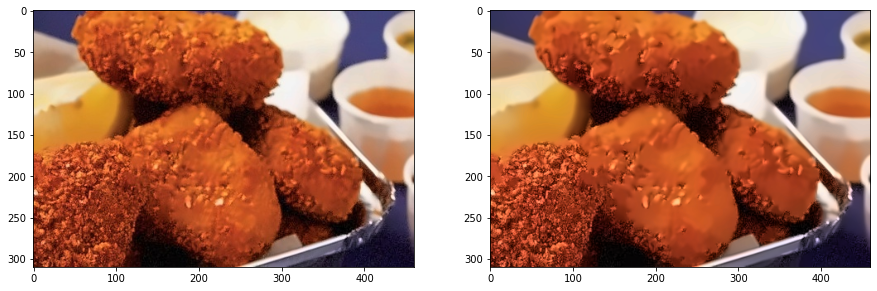

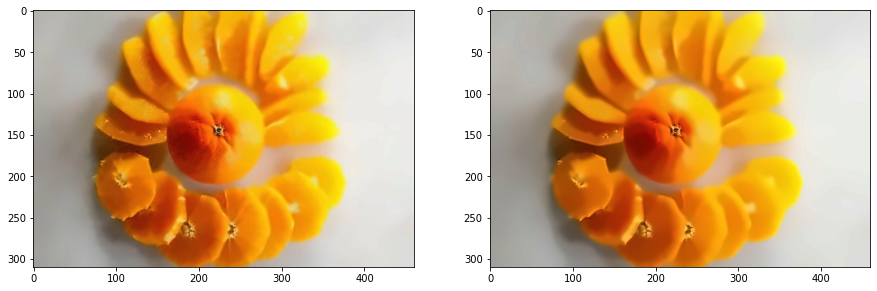

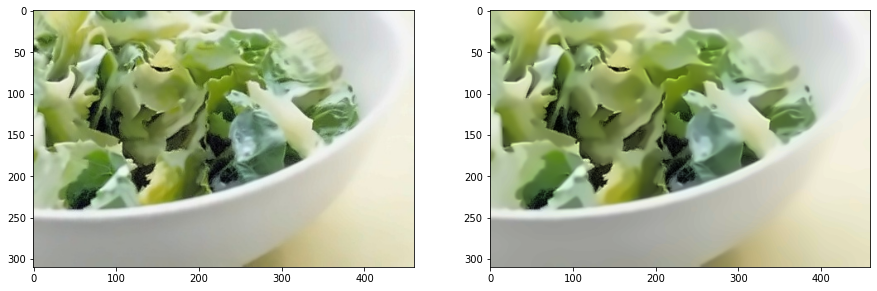

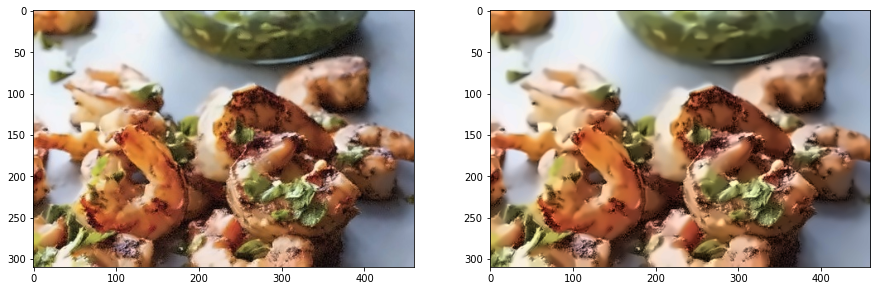

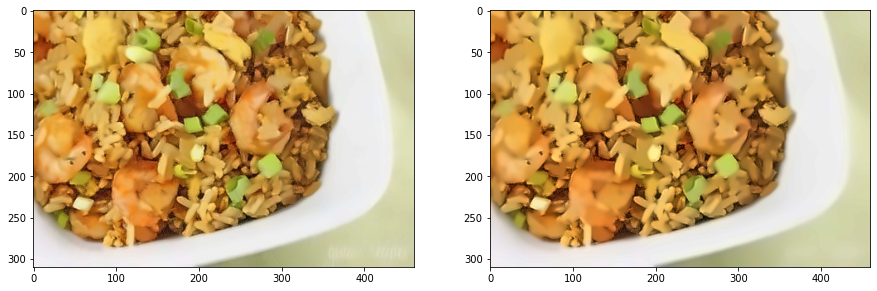

(310, 460, 3)

In [21]:
for image in images[100:105]:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dst = cv2.fastNlMeansDenoisingColored(image, None, 8, 8, 7, 21)
    f = plt.figure()
    f.set_figheight(15)
    f.set_figwidth(15)
    f.add_subplot(1,2, 1)
    plt.imshow(image)
    f.add_subplot(1,2, 2)
    plt.imshow(dst)
    plt.show(block=True)

images[0].shape

In [41]:
USE_VALIDATION = True
VALIDATION_FRACTION = 0.02
TRAIN_LABEL_TRIPLETS_FRACTION = 1

In [42]:
def load_triplet_labels(triplet_labels_fp):
    label_triplets = []

    for line in open(triplet_labels_fp, 'r'):
        anchor, positive, negative = tuple(map(int, line.split()))
        label_triplets.append((anchor, positive, negative))
        
    return label_triplets
train_label_triplets = load_triplet_labels('/content/drive/MyDrive/task3/train_triplets.txt')
test_label_triplets = load_triplet_labels('/content/drive/MyDrive/task3/test_triplets.txt')
        

In [43]:
train_label_triplets_size = len(train_label_triplets) * TRAIN_LABEL_TRIPLETS_FRACTION

if USE_VALIDATION:
    validation_triplets = train_label_triplets[int(-VALIDATION_FRACTION*train_label_triplets_size):]
    train_triplets = train_label_triplets[:int((1-VALIDATION_FRACTION)*train_label_triplets_size)]
else:
    validation_triplets = None
    train_triplets = train_label_triplets
    

In [44]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class TripletImageDataset(Dataset):
    
    def __init__(self, triplets, transform=None):
        """Create triplets from triplet_labels_fp"""
        self.triplets = triplets
        self.transform = transform
        
    # Required for Map-style dataset
    def __getitem__(self, index):
        i_1, i_2, i_3 = self.triplets[index]
        img_1 =  Image.fromarray(cv2.cvtColor(images[i_1], cv2.COLOR_BGR2RGB))
        img_2 = Image.fromarray(cv2.cvtColor(images[i_2], cv2.COLOR_BGR2RGB))
        img_3 = Image.fromarray(cv2.cvtColor(images[i_3], cv2.COLOR_BGR2RGB))
        return self.transform(img_1), self.transform(img_2), self.transform(img_3)

    # Required for Map-style dataset
    def __len__(self):
        return len(self.triplets)
    
    def _img_to_tensor(self, img):
        return img.to(device)
    
    def generate_batches(self, batch_size, shuffle=True, drop_last=True):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)

        for img1, img2, img3 in dataloader:
            yield self._img_to_tensor(img1), self._img_to_tensor(img2), self._img_to_tensor(img3)
        

In [ ]:
j = images[0].reshape(images[1].size(0), -1)


TypeError: 'int' object is not callable

In [45]:
import torch.nn as nn

class NeuralNet(nn.Module):
    
    EMBEDDING_DIM = 64
    
    def __init__(self, inp = 2208, hidden=768, hidden_2=400, d=0.2):
        super(NeuralNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(inp, hidden),
            nn.PReLU(),
            nn.BatchNorm1d(hidden),
            nn.Dropout(d),
            nn.Linear(hidden, hidden_2),
            nn.PReLU(),
            nn.BatchNorm1d(hidden_2),
            nn.Dropout(d),
            nn.Linear(hidden_2, NeuralNet.EMBEDDING_DIM)
        )
        
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)

    

In [46]:
def closest_image(anchor, positive, negative):
    """
    Returns: 
        int: 1 if the anchor is more similar to the positive image. 
                0 if anchor is more similar to the negative image.
                
    Note:
        Works for batches. 
        Each input tensor should have this shape: `N x W x H x C` 
        where `N` is the number of samples.
    """
    pairwise_dist = nn.PairwiseDistance(p=2)
    distance_pos = pairwise_dist(anchor, positive)
    distance_neg = pairwise_dist(anchor, negative)
    return (~(distance_pos >= distance_neg).to(torch.bool)).to(torch.int32)

In [47]:
def accuracy(pred, gold):
    return np.mean((pred == gold))

In [48]:
import torchvision
from torchvision import models

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    if model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = NeuralNet(inp=num_ftrs) 
        input_size = 224
    elif model_name == "resnet":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = NeuralNet(inp=num_ftrs) 
        input_size = 224
    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, NeuralNet.EMBEDDING_DIM)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = NeuralNet(inp=num_ftrs)
        input_size = 299


    return model_ft, input_size

feature_extract = True

# Initialize the model for this run
model_type = 'densenet'
model_pretrained, input_size = initialize_model(model_type, 128, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_pretrained)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [49]:
model_pretrained = model_pretrained.to(device)
params_to_update = model_pretrained.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in model_pretrained.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_pretrained.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 classifier.fc.0.weight
	 classifier.fc.0.bias
	 classifier.fc.1.weight
	 classifier.fc.2.weight
	 classifier.fc.2.bias
	 classifier.fc.4.weight
	 classifier.fc.4.bias
	 classifier.fc.5.weight
	 classifier.fc.6.weight
	 classifier.fc.6.bias
	 classifier.fc.8.weight
	 classifier.fc.8.bias


In [50]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [51]:
def predict(model, predict_set):
    """Predict 0/1 for the given predict_set (Dataset)"""
    predict_set_choices = []
    # List of tuples which the model chose as most similar
    model.eval()
    with torch.no_grad():
        for anchor_img, positive_img, negative_img in tqdm(predict_set.generate_batches(batch_size, shuffle=False, drop_last=False), leave=True, total=len(predict_set) // batch_size):
            # Get embeddings from our model
            anchor_emb = model(anchor_img)
            positive_emb = model(positive_img)
            negative_emb = model(negative_img)

            # Compute distances and the corresponding labels
            labels = closest_image(anchor_emb, positive_emb, negative_emb)

            predict_set_choices.append(labels.cpu().numpy())
    result = np.array(predict_set_choices).flatten()
    return np.concatenate(result).ravel()
            

TypeError: 'int' object is not callable

In [52]:
class Training:
    
    def __init__(self, is_inception=False):
        self.is_inception = is_inception
    
    def start(self, model, optimizer, dataset, criterion, scheduler, batch_size, epochs=15, starting_epoch=0, model_name='model.pth'):
        nr_batches = len(dataset) // batch_size
        progress_bar = tqdm(desc='', total=epochs * nr_batches,
            leave=False
        )
        
        # Start the training
        for epoch in range(epochs):
            epoch += starting_epoch
            model.train()
            losses = AverageMeter('Loss', ':.3f')
            running_pred = []
            batches = dataset.generate_batches(batch_size)
            for batch_index, (anchor_img, positive_img, negative_img) in enumerate(batches):
                progress_bar.set_description_str("E {} | B {}".format(
                    epoch+1, batch_index
                ))
                
                optimizer.zero_grad()
                # Compute loss for two outputs if we are using Inception
                if self.is_inception:
                    anchor_out, anchor_aux = model(anchor_img)
                    positive_out, positive_aux = model(positive_img)
                    negative_out, negative_aux = model(negative_img)
                    
                    loss1 = criterion(anchor_out, positive_out, negative_out)
                    loss2 = criterion(anchor_aux, positive_aux, negative_aux)
                    loss = loss1 + 0.4*loss2
                    
                else:
                    
                    anchor_out = model(anchor_img)
                    positive_out = model(positive_img)
                    negative_out = model(negative_img)

                    loss = criterion(anchor_out, positive_out, negative_out)

                losses.update(loss.item(), anchor_img.size(0))
                loss.backward()
                optimizer.step()
                
                predicted_labels = closest_image(anchor_out, positive_out, negative_out).cpu().numpy()
                acc_t = accuracy(predicted_labels, np.ones_like(predicted_labels))
                running_pred.append(predicted_labels)
                
                progress_bar.set_postfix_str("{} | BatchAcc={:.3f}".format(losses, acc_t))
                progress_bar.update()
                
            # Save the model
            model_fp = 'trained_models/' + model_name
            if not os.path.exists(model_fp):
                os.makedirs(model_fp)
            torch.save(model.state_dict(), os.path.join(model_fp, "{}_epoch{}.pth".format(model_name, epoch)))
            
            if validation_triplets is not None:
                validation_set = TripletImageDataset(validation_triplets, val_set_transform)
                validation_set_predictions = predict(model, validation_set)
                validation_acc = accuracy(validation_set_predictions, np.ones_like(validation_set_predictions))
            
            # Compute accuracy
            predictions = np.array(running_pred).flatten()
            acc = accuracy(predictions, np.ones_like(predictions))
            
            # Change LR for next epoch
            if scheduler is not None:
                scheduler.step()
            
            # Update progress bar
            progress_bar.write(
                "[Epoch {}/{}]: {}, Val Accuracy {}, Train Accuracy {}".format(
                    epoch+1, epochs+starting_epoch, losses, validation_acc, acc
                )
            )
            progress_bar.refresh()

In [53]:
from torchvision import transforms

train_set_transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_set = TripletImageDataset(train_triplets, train_set_transform)

In [54]:
val_set_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_set = TripletImageDataset(test_label_triplets)

In [55]:
criterion_pretrained = nn.TripletMarginLoss(margin=0.5)
optimizer_pretrained = torch.optim.Adam(params_to_update, lr=0.001)
scheduler_pretrained = None

batch_size = 64
epochs_pretrained = 10
starting_epoch = 0

is_inception=model_type == "inception"
# Start the training
Training(is_inception=is_inception).start(
    model_pretrained, 
    optimizer_pretrained, 
    train_set, 
    criterion_pretrained, 
    scheduler_pretrained,
    batch_size,
    starting_epoch=starting_epoch,
    epochs=epochs_pretrained,
    model_name='final_densenet_model'
)

  0%|          | 0/9110 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


[Epoch 1/10]: Loss 0.500 (0.568), Val Accuracy 0.692436974789916, Train Accuracy 0.6315175631174533


  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch 2/10]: Loss 0.577 (0.448), Val Accuracy 0.7016806722689075, Train Accuracy 0.6717034851811197


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


[Epoch 3/10]: Loss 0.341 (0.395), Val Accuracy 0.6890756302521008, Train Accuracy 0.697293496158068


  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch 4/10]: Loss 0.337 (0.368), Val Accuracy 0.7142857142857143, Train Accuracy 0.7097111690450055


  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch 5/10]: Loss 0.314 (0.344), Val Accuracy 0.7260504201680672, Train Accuracy 0.7228492041712404


  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch 6/10]: Loss 0.324 (0.322), Val Accuracy 0.7310924369747899, Train Accuracy 0.7360215422612514


  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch 7/10]: Loss 0.325 (0.308), Val Accuracy 0.7361344537815127, Train Accuracy 0.7457121295279913


  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch 8/10]: Loss 0.227 (0.293), Val Accuracy 0.7361344537815127, Train Accuracy 0.7555742316136114


  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch 9/10]: Loss 0.271 (0.278), Val Accuracy 0.7478991596638656, Train Accuracy 0.768077661909989


  0%|          | 0/18 [00:00<?, ?it/s]

[Epoch 10/10]: Loss 0.338 (0.267), Val Accuracy 0.7512605042016807, Train Accuracy 0.7778540065861691


In [1]:
train_set_predictions_pretrained = predict(model_pretrained, train_set)
print("Train set accuracy [pre-trained model]: {}".format(accuracy(train_set_predictions_pretrained, np.ones_like(train_set_predictions_pretrained))))

NameError: ignored

NameError: ignored